<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/%E2%80%9CBitcoin_Price_and_its_Movement_Direction_Prediction_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Packages**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/bitcoin.csv") 

Modify Timestamp

In [4]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')
df = df.resample("24H").mean()

Spot the missing values

In [5]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [6]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [7]:
df = df.dropna()

# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [8]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

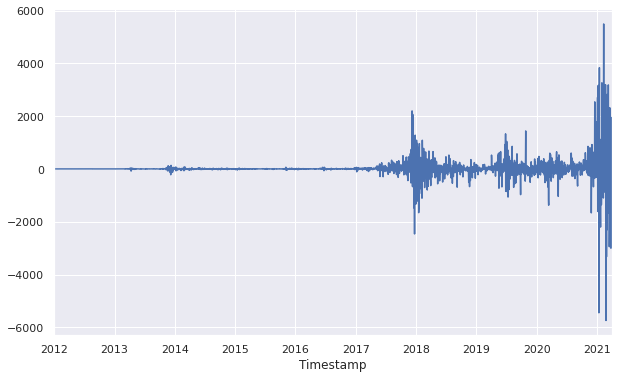

In [9]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [10]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

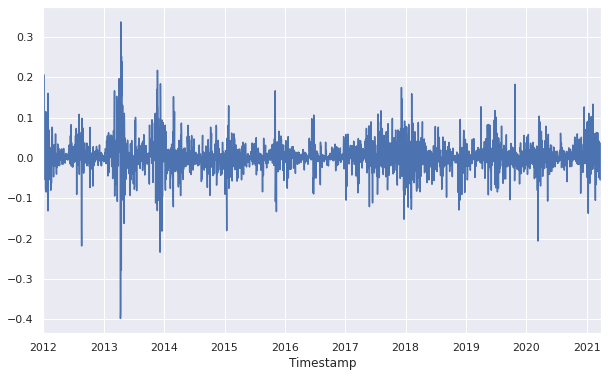

In [11]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [12]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,4.806667,0.332917,Up,0.074416,0.040222,0.050500,-0.007774,0.205720,0.024856
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,5.000000,0.193333,Up,0.040222,0.050500,-0.007774,0.205720,0.024856,0.055901
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,5.252500,0.252500,Up,0.050500,-0.007774,0.205720,0.024856,0.055901,0.022059
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,5.211667,-0.040833,Down,-0.007774,0.205720,0.024856,0.055901,0.022059,-0.052818
2012-01-05,6.281429,6.286190,6.281429,6.286190,4.514373,27.987370,6.284127,6.283810,1.072143,Up,0.205720,0.024856,0.055901,0.022059,-0.052818,0.003051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22,56789.786370,56827.052114,56751.404145,56789.432469,4.566736,255685.092495,56787.148422,56789.418774,-525.423089,Down,-0.009167,-0.036704,0.007704,-0.054452,0.021435,0.036668
2021-03-23,54704.396340,54741.990215,54667.339653,54706.291854,3.469766,189536.245426,54703.387740,54705.004516,-2084.414259,Down,-0.036704,0.007704,-0.054452,0.021435,0.036668,0.011594
2021-03-24,55126.661216,55169.567708,55082.660874,55126.809462,4.799137,263511.724378,55123.993855,55126.424815,421.420299,Up,0.007704,-0.054452,0.021435,0.036668,0.011594,0.019366


Cleaned Dataset Display

In [13]:
df.shape

(3379, 16)

In [14]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,4.473750,NaN,Down,NaN,0.074416,0.040222,0.050500,-0.007774,0.205720
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,4.806667,0.332917,Up,0.074416,0.040222,0.050500,-0.007774,0.205720,0.024856
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,5.000000,0.193333,Up,0.040222,0.050500,-0.007774,0.205720,0.024856,0.055901
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,5.252500,0.252500,Up,0.050500,-0.007774,0.205720,0.024856,0.055901,0.022059
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,5.211667,-0.040833,Down,-0.007774,0.205720,0.024856,0.055901,0.022059,-0.052818


#**Exploratory Data Analysis**

Zheming's Part

bitcoin moving average


In [19]:
import plotly.graph_objects as go
trace1 = {
    'x': df.index,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': 'MSFT',
    'showlegend': False
}
# Calculate and define moving average of 30 periods
avg_30 = df.Close.rolling(window=30, min_periods=1).mean()

# Calculate and define moving average of 50 periods
avg_50 = df.Close.rolling(window=50, min_periods=1).mean()

trace2 = {
    'x': df.index,
    'y': avg_30,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'blue'
            },
    'name': 'Moving Average of 30 periods'
}

trace3 = {
    'x': df.index,
    'y': avg_50,
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'red'
    },
    'name': 'Moving Average of 50 periods'
}
data_trace = [trace1, trace2, trace3]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Bitcoin Moving Averages',
        'font': {
            'size': 15
        } 
    }
})




fig = go.Figure(data=data_trace, layout=layout)
fig.show()




Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

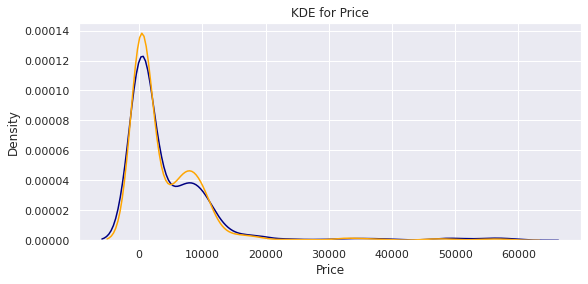

In [16]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

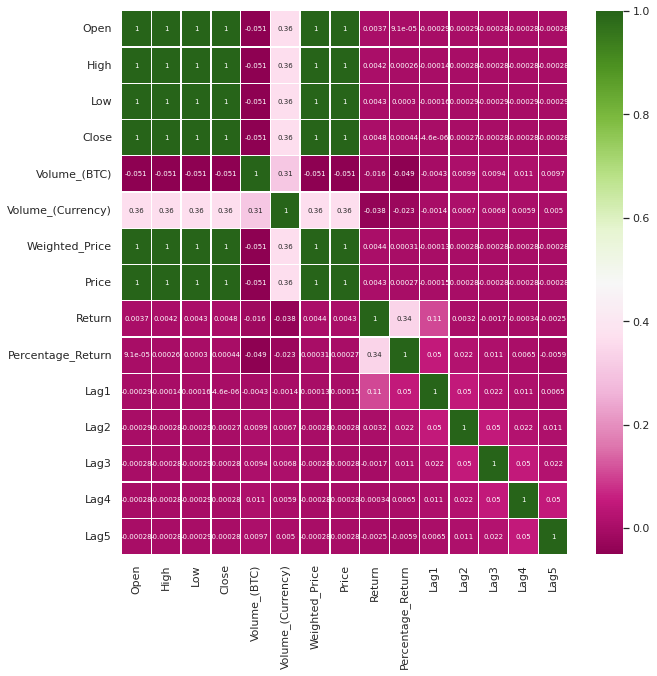

In [ ]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [17]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



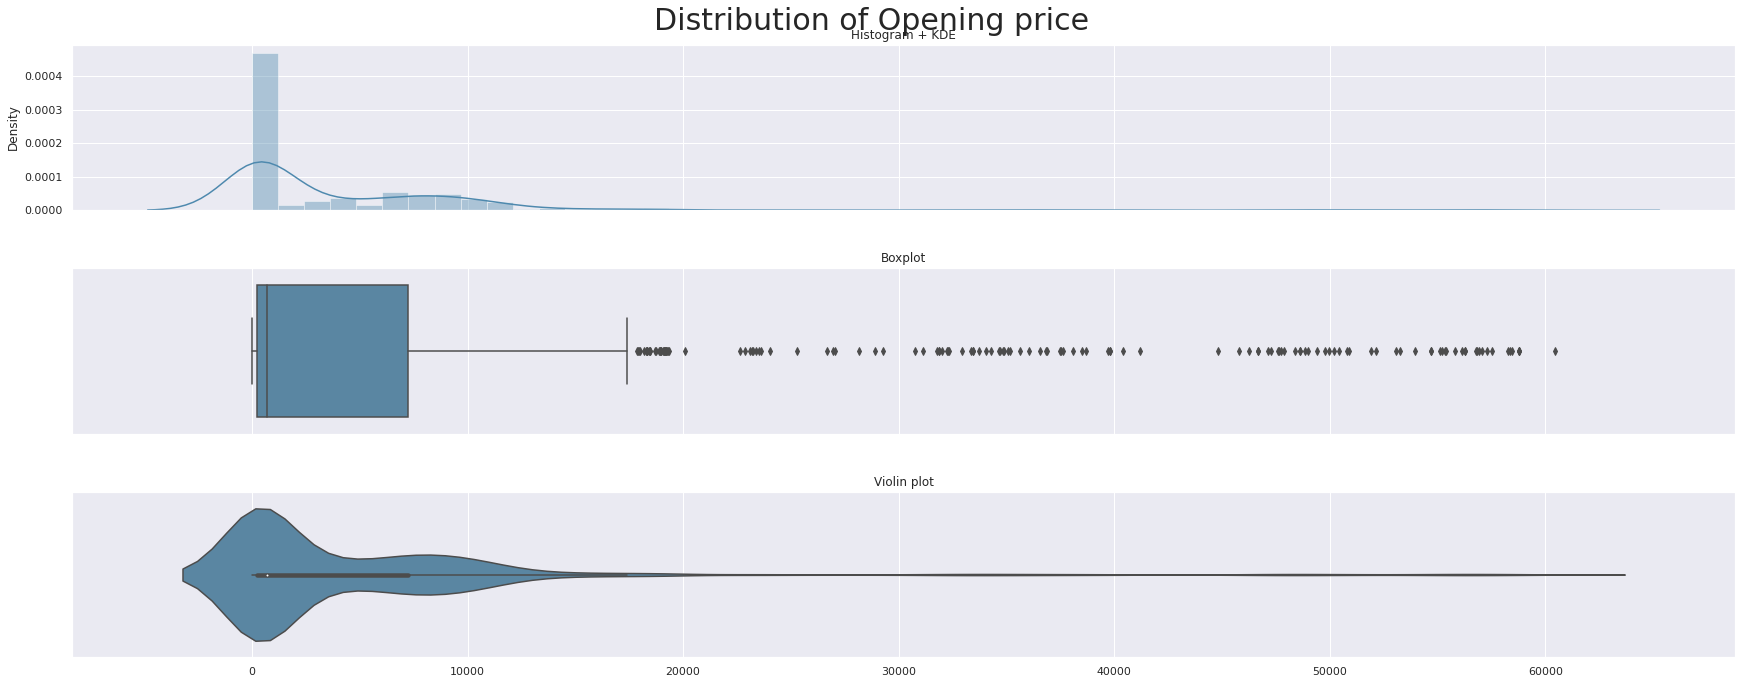

In [18]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

# **ARIMA Model**

Geech's part here

# **Simple RNN**

Yihan Jia's part here

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm